# Data Mining for Business Analytics
## Discriminant Functions

Spring 2019 - Prof. George Valkanas

Material based on content courtesy of Prof. Foster Provost

***

### Downloading & Installing Packages
There are some packages that will be required for this assignment that are no pre-loaded into Jupyter hub. You can install them following the instructions below.

Enter the following commands into jupyter's terminal one at a time:
```
sudo pip install liac-arff
sudo apt install graphviz
sudo pip install graphviz
sudo pip install pydotplus
```
enter "`Y`" when promted.

### Scripts and Data

In addition to Python Notebooks, we often write our code in Python scripts.  These are separate files, where we typically include things that we want to reuse very often, not just within the Notebook itself.  We can use them as part of other work that we may be doing (e.g., during deployment) or reference them from multiple notebooks.  That way the code doesn't clutter up the notebook and in case we have a fix for a problem in the code, then we don't need to change it in many places!

We import and use these scripts in our code just like we do with any other Python module (e.g., Pandas). Basically, we don't care about seeing the actual code of these functions, as long as they work correctly.  All that we need to know / remember / understand is their functionality, i.e., what we need to pass as input and what they return as output.

Take a look at the following:

* We use the folder **_dstools_** that is in the same directory (folder) as this notebook
* We import the file: **data\_tools**

This file is a   ".py" which has Python commands and functions, such as:

1. Decision_Surface -- this is the function that visualizes the segmentation of the learned model
2. Color_Data_Points -- this creates the artificial data set, for us to experiment with

After the "import" we can use these 3 functions, just like we use pre-defined packages like Pandas.

### Packages

In [1]:
# Import the libraries we will be using

import numpy as np
import pandas as pd # importing cuteness

# Importing the modules from SKLEARN that we are going to use today
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import svm

import os
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image
from sklearn import datasets

from dstools import data_tools


# for plotting
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 10







## Data & Functions
Let's revisit briefly the dataset that we used previously. It's a 2D dataset, representing customers that we reached out in the past with an ad-campaign. For each customer, we know their age and the number of years as a customer (when we ran the ad).

In [2]:
# Set the randomness
#change data here
np.random.seed(969)

# Number of users, i.e. number of instances in our dataset
n_users = 500

# Features that we know about each user. The attributes below are for illustration purposes only!
variable_names = ["name", "age", "years_customer"]
variables_keep = ["years_customer", "age"]
target_name = "response"

# Generate data with the "datasets" function from SKLEARN (package)
# This function returns two variables: predictors and target

predictors, target = datasets.make_classification(n_features=3, n_redundant=0, 
                                                  n_informative=2, n_clusters_per_class=2,
                                                  n_samples=n_users)

# We will write this data in a dataframe (pandas package)

data = pd.DataFrame(predictors, columns=variable_names)

# We want to take each column of the dataframe to change the values 

data['age'] = data['age'] * 10 + 50
data['years_customer'] = (data['years_customer'] + 6)/2
data[target_name] = target

# Our variables (features) will be stored in one variable called X
X = data[variables_keep]

# Our target will be stored in one variable called Y
Y = data[target_name]


In [3]:
# Just to see how the responses are distributed
#just the basic statistics about the dataset
data.groupby("response").count()

,name,age,years_customer
response,,,
0,250,250,250
1,250,250,250


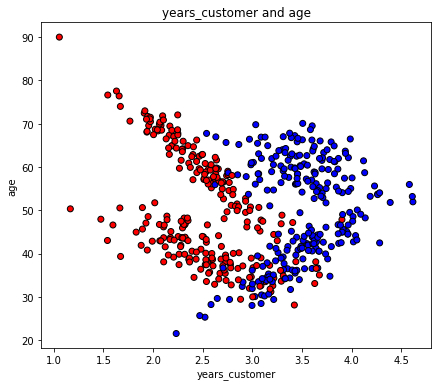

In [4]:
# Let's visualize the dataset to remember it
#print yes or no dots
plt.figure(figsize=[7,6])
data_tools.Decision_Surface(X, Y, model=None, probabilities=False)

Let's look at our data one more time by projecting them on the `years_customer` feature, which we've established looks like a better way to separate them. In fact, let's put everything on a single line.

In [5]:
# Set the best feature here after looking at the data above
best_feat = 'years_customer'

In [6]:

# Specify the color for each data point, based on the response
color = data_tools.Color_Data_Points(data["response"])


# Select all of the rows / records that have a positive response.
# The result of the right hand side is a DataFrame
negat_response = data.loc[data["response"] == 0]
posit_response = data.loc[data["response"] == 1]

# Minimum and maximum value for the best performing feature
bfeat_value_range = (X[best_feat].min(), X[best_feat].max())


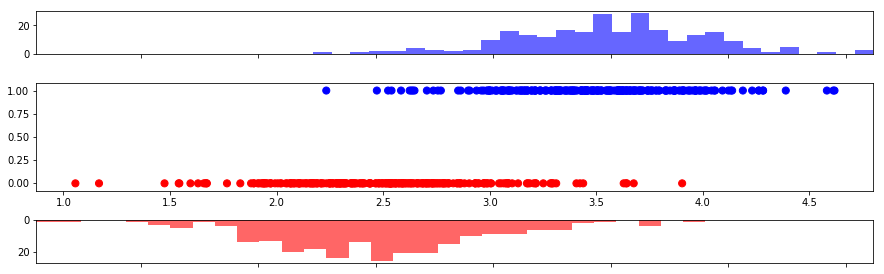

In [7]:
from matplotlib.ticker import NullFormatter
plt.rcParams['figure.figsize'] = [15.0, 2.0]

# This formatter will change the appearance of the ticks on the x-axes
noTicksFmtr = NullFormatter()

# Specifying the size (and partly, the location) of the canvas area for the distribution
hist_height = 0.3
hist_gap = 0.2


# Method that creates a particular histogram plot
def create_hist_plot( canvas_size, bfeat_value_range, plot_data, color ):
    bounds_plot = plt.axes( canvas_size )
    bounds_plot.xaxis.set_major_formatter(noTicksFmtr)
    bounds_plot.xaxis.set_major_formatter(noTicksFmtr)
    bounds_plot.set_xlim(bfeat_value_range)
    bounds_plot.hist( plot_data, color=color, alpha=0.6, bins=30)
    return bounds_plot


rect_histx = plt.axes()
rect_histx.scatter(X[best_feat], Y, c=color, s=50)
bounds = rect_histx.get_position().bounds


# Compute the bounds for the histogram that is ABOVE. Plot it
hist_canvas = [ bounds[0], bounds[1] + bounds[3] + hist_gap, bounds[2], hist_height ]
hist_plot = create_hist_plot(hist_canvas, bfeat_value_range, posit_response[best_feat], 'b')


# Compute the bounds for the histogram that is Below. Plot it
hist_canvas = [ bounds[0], bounds[1] - (hist_gap + hist_height), bounds[2], hist_height ]
hist_plot = create_hist_plot(hist_canvas, bfeat_value_range, negat_response[best_feat], 'r')
hist_plot.invert_yaxis()  # Turn the historgam upside down

plt.show()

## Linear discriminant models

Instead of doing the whole "entropy and the information gain" thing, one could argue that the data exhibit a nice-looking linear relation. The greater the value for our best performing feature, the more likely they will respond (`y=1`). The lower the value, the less likely (`y=0`).


Following the above rationale, we can build a linear model that will help us separate the two classes. The simplest linear model that we know is linear regression, which looks like this:

$$ f({\bf x}) = y = b + a_1 x_1 + a_2 x_2 + a_3 x_3 + ... $$


Looking at the data (see scatterplot above), can you estimate by eye where a good linear discriminant would be?


Since we are looking for a linear discriminant, an immediate thought is to use linear regression. Let's do that now.

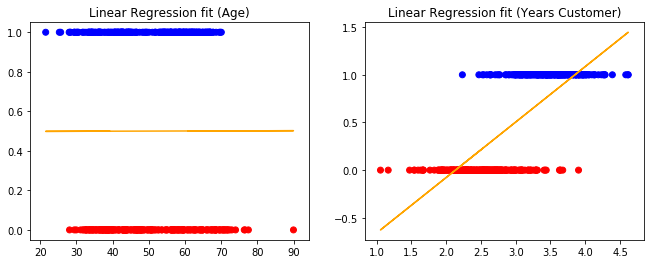

In [8]:
def plot_linreg_model(x_feats, y, title=''):
    
    # Let's learn a LINEAR regression model
    model_lin = LinearRegression()
    model_lin.fit(x_feats, y)

    y_lin = model_lin.predict(x_feats)

    plt.plot(x_feats, y_lin, 'orange')  # If you cannot see the orange lines, change the color to 'black'
    plt.scatter(x_feats, y, c=color)
    plt.title("Linear Regression fit" + title)
    return


plt.figure(figsize=[11,4])

# Create a linear regression model for the "age"
plt.subplot(1, 2, 1)
plot_linreg_model( X['age'].values.reshape(-1, 1), Y.values.reshape(-1, 1), title=' (Age)' )

# Create a linear regression model for the "years_customer"
plt.subplot(1, 2, 2)
plot_linreg_model( X['years_customer'].values.reshape(-1, 1), Y.values.reshape(-1, 1), title=' (Years Customer)' )

plt.show()

**Question 1:** Does this look correct? Why? Why not?

**Question 2:** Can we somehow _recast_ what we are trying to compute?

***

#### Logistic Regression
Linear regression is a great tool, but doesn't fit our purpose. In situations like this, instead, we use what is called **Logistic Regression**.

Logistic Regression is used to quantify the _probability_ that an instance **x** belongs to a particular class. The Logistic Regression model recasts the original linear equation and solves the following:

$$\log \frac{p_c({\bf x})}{1 - p_c({\bf x})} = f({\bf x}) = w_0 + w_1*x_1 + w_2*x_2 + \dots $$

where $p_c({\bf x})$ refers to the probability that instance ${\bf x}$ belongs to the target class of interest $c$. This is the **log-odds** linear function.
<br/>
<br/>


**Question 1:** What is the model that we learn here?


**Question 2:** What is the target class of _interest_ in our example?

***

Below we build and visualize a **Logistic regression** model. You can also find logistic regression modeling in the sklearn package.

To get a better comparative sense with linear regression, we show the two models side by side.

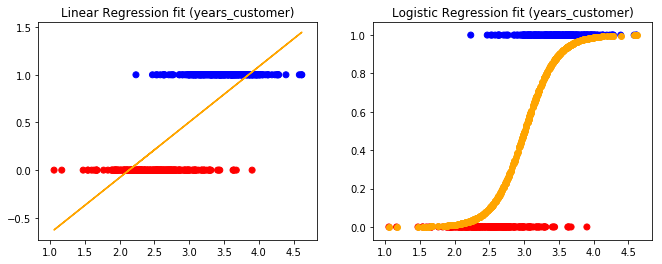

In [9]:

def plot_logreg_model(x_feats, y, title=''):
    
    # Let's learn a LINEAR regression model
    model_log = LogisticRegression(solver='lbfgs')
    model_log.fit(x_feats, y)

    y_hat = model_log.predict_proba(x_feats)[:,1]

    plt.scatter(x_feats, y, c=color)
    plt.scatter(x_feats, y_hat, c='orange')   # If you cannot see the orange lines, change the color to 'black'
    plt.title("Logistic Regression fit" + title)
    return


# Create a plot object that will contain 2 subplots
plt.figure(figsize=[11,4])

# Generate (and plot) a LINEAR model with our best feature 
plt.subplot(1, 2, 1)
plot_linreg_model( X[best_feat].values.reshape(-1, 1), Y.ravel(), title=' ({})'.format(best_feat) )

# Generate (and plot) a LOGISTIC model with our best feature
plt.subplot(1, 2, 2)
plot_logreg_model( X[best_feat].values.reshape(-1, 1), Y.ravel(), title=' ({})'.format(best_feat) )

plt.show()

In [10]:

# Let's create another dataset where we maintain our best performing feature only.
# We will do that by copying the existing feature set and setting the value of the poor feature to 0
one_feat_df = X.copy()
best_feat_index = X.columns.values.tolist().index(best_feat)
non_good_feat = X.columns.values.tolist()[1 - best_feat_index]  # Can you see why this works?
one_feat_df[non_good_feat] = np.zeros(len(X))


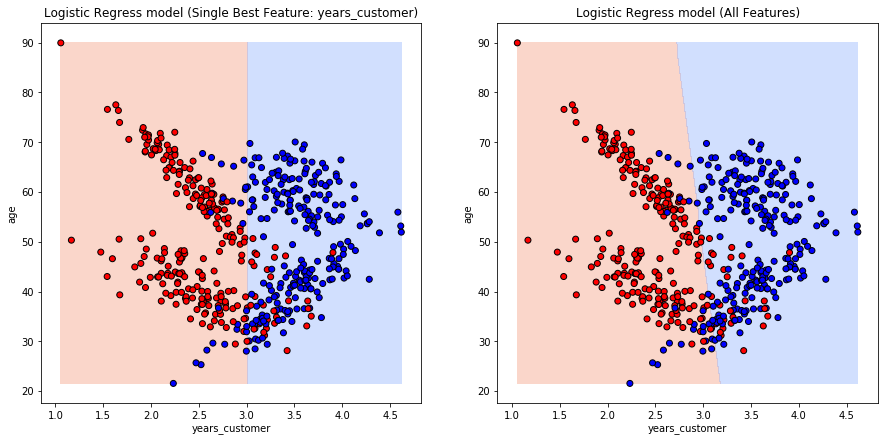

In [11]:
# Let's build a logistic regression model using all of our features and show the decision surface

# Plot the result
plt.figure(figsize=[15,7])


# Let's learn a LOGISTIC regression model using the most informative feature
model = LogisticRegression(solver='lbfgs')
model.fit(one_feat_df, Y)

plt.subplot(1,2,1)
# Our method expects a DATAFRAME as X value. This is why we must use the X[['feat']] notation
data_tools.Decision_Surface(X, Y, model=model, probabilities=False)
plt.title("Logistic Regress model (Single Best Feature: {})".format(best_feat))


# Train the model with all the features
model = LogisticRegression(solver='lbfgs')
model.fit(X, Y)

plt.subplot(1,2,2)
data_tools.Decision_Surface(X, Y, model=model, probabilities=False)
plt.title("Logistic Regress model (All Features)")

plt.show()

## Estimating Probabilities

Ok.  For many business problems, we don't need just to estimate the categorical target variable, but we want to estimate the probability that a particular value will be taken.  Just about every classification model can also tell you the estimated probability of class membership.  

Let's go back and look at the probabilities estimated by these models. You can visualize the probabilities both for the linear model and the tree-structured model. You can do this by modifying the settings at the top of each code block above **(`show_probabilities = True` or `False`)**.

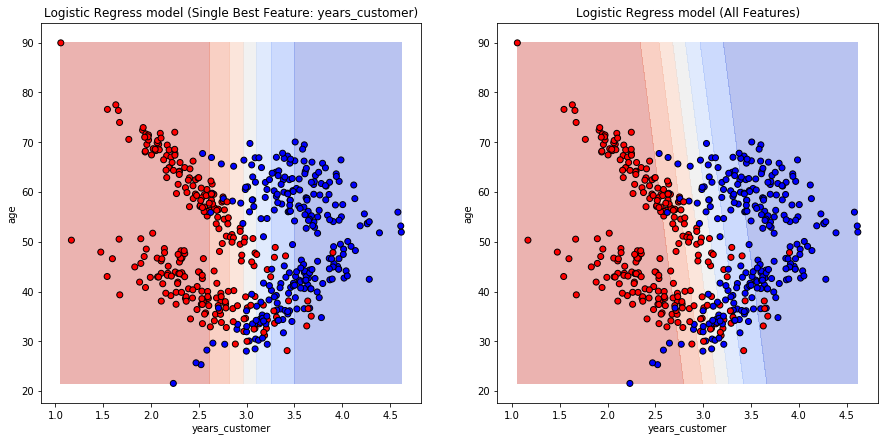

In [12]:
# Let's build a logistic regression model using all of our features and show the decision surface

# Plot the result
plt.figure(figsize=[15,7])


# Let's learn a LOGISTIC regression model using the most informative feature
model = LogisticRegression(solver='lbfgs')
model.fit(one_feat_df, Y)

plt.subplot(1,2,1)
# Our method expects a DATAFRAME as X value. This is why we must use the X[['feat']] notation
data_tools.Decision_Surface(X, Y, model=model, probabilities=True)
plt.title("Logistic Regress model (Single Best Feature: {})".format(best_feat))


# Train the model with all the features
model = LogisticRegression(solver='lbfgs')
model.fit(X, Y)

plt.subplot(1,2,2)
data_tools.Decision_Surface(X, Y, model=model, probabilities=True)
plt.title("Logistic Regress model (All Features)")

plt.show()

### Probability Estimation and Laplace Correction

Let's say that we are working with a Decision Tree classifier, for a binary classification problem (e.g., customer churn). Let's say that for a given instance to predict, we end up in a _leaf node_ with the following information:

**Count(** churn=`'yes'` **):** 10

**Count(** churn=`'no'` **):** 0


#### Question: What is the _probability_ that the customer will leave the service?


***


Remember that our models are learned from data that we have available. The model aims to learn the underlying "nature" (read: distribution) of the function / process that generated the data we are working with. Therefore, our **observations** may be incomplete and it's possible that we are missing some data points.

Why does this matter? How does this affect probability estimation?

$$ p(c) = \frac{n + 1}{n + m + 2} $$

which yields the following probability estimates

<img width="50%" src="images/laplace_correction.png"/>

***

## Support Vector Machines

Support Vector Machines compute the line (or hyper-plane) that best separates the data points which are closest to the **decision boundary**. These data points are called _support vectors_.

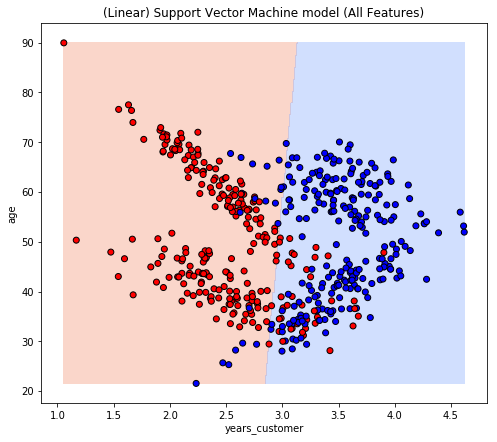

In [13]:
plt.figure(figsize=[8,7])

# Let's learn a Linear Support Vector Machine. You can also try an SVC instead of LinearSVC
model = svm.LinearSVC(C=0.1, max_iter=100000)  # Try the following model: svm.SVC(gamma='scale', max_iter=100000)
model.fit(X, Y)

# Our method expects a DATAFRAME as X value. This is why we must use the X[['feat']] notation
data_tools.Decision_Surface(X, Y, model=model, probabilities=False)
plt.title("(Linear) Support Vector Machine model (All Features)")

plt.show()


### Comprehension Questions

**Question 1:** Why do we call it logistic _regression_ although we are clearly using it for classification? Doesn't that contradict our definition of classification?

**Question 2:** Intuitively, how would you generate probabilities from a classification tree? From a linear discriminant? 

## Take home question (or in class)
##### + 2p credit

Combine the code that we have seen here and the code from the Decision Trees notebook and produce plots that show the decision surfaces in a probabilistic manner. Do the same for trees with depth 1, 2, 3, 4 and 5. Each tree will be in its own plot.

Instructions for your code
* Use the numerical value of your NetID to set the `randomness` 
* Generate a **single** dataset
* Write your code and generate the 5 different plots above.
* Save each plot, either manually or programmatically, as `<NetID>_<depth>.jpg` or `<NetID>_<depth>.png`, where `<NetID>` refers to your NetID and `<depth>` refers to the depth of the tree that you are showing. For example, a file with the name `gv760_3.png` is from user gv760 (that's me) and the visualized tree has `depth=3`.
* Send both the images and your code (ipython notebook).

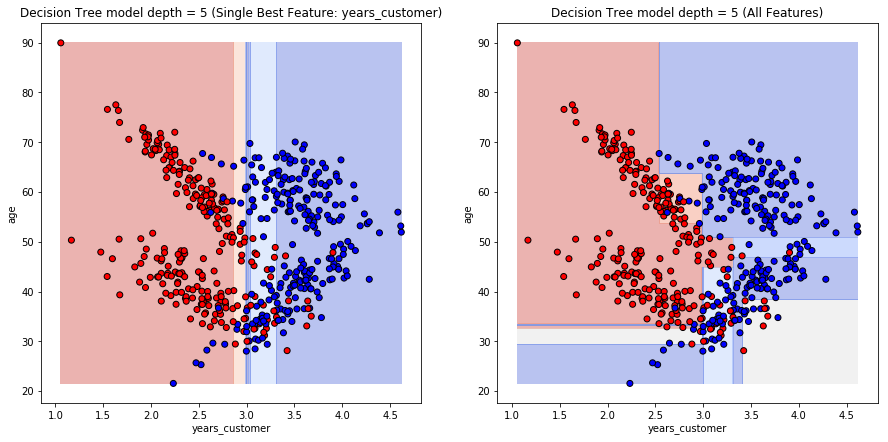

In [22]:
# Let's build a decision tree model using all of our features and show the decision surface

#change the random data at the very beginning by changing into random.seed(969)

# Plot the result
plt.figure(figsize=[15,7])


# Let's learn a LOGISTIC regression model using the most informative feature
model = DecisionTreeClassifier(max_depth=5,criterion="entropy")  
model.fit(one_feat_df, Y)

plt.subplot(1,2,1)
# Our method expects a DATAFRAME as X value. This is why we must use the X[['feat']] notation
data_tools.Decision_Surface(X, Y, model=model, probabilities=True)
plt.title("Decision Tree model depth = 5 (Single Best Feature: {})".format(best_feat))


# Train the model with all the features
model = DecisionTreeClassifier(max_depth=5,criterion="entropy")  
model.fit(X, Y)

plt.subplot(1,2,2)
data_tools.Decision_Surface(X, Y, model=model, probabilities=True)
plt.title("Decision Tree model depth = 5 (All Features)")

plt.show()